In [1]:
%matplotlib inline
import os, pickle
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

font_path = "/home/zhoujb/local/font/Times New Roman.ttf"
mpl.font_manager.fontManager.addfont(font_path)
prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/Result/"
CROSS_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/Cross_Analysis_Results/rawCross/"
CROSS_RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/Cross_Analysis_Results/CrossRes/"
RAW_CROSS_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/Cross_Analysis_Results/"
FIG_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/plotFigure/"

In [2]:
p2_info = pd.read_table(os.path.join(RAW_CROSS_PATH, "P1_P2_CROSS_TOP10_P2_info.txt"))
p2_top10 = p2_info.head(10)
p2_top10

,P2,P2_score,P2_donate_times,Optimal_score_mean,Delta_score_mean,Same_mean,Keep_mean,Replaced_by_P2_mean
0,D554,98.030498,132,99.402176,37.635561,471.606061,21.507576,311.886364
1,D412,98.171046,113,99.456258,35.689954,477.106195,27.389381,300.504425
2,D475,98.360822,108,99.409069,41.327014,442.055556,23.398148,339.546296
3,D491,97.911200,101,99.483587,31.744298,512.544554,25.702970,266.752475
4,D501,97.911200,99,99.499505,30.448227,522.040404,25.858586,257.101010
5,D487,97.911200,98,99.509923,29.896358,525.775510,25.897959,253.326531
6,D502,97.911200,98,99.501334,30.600566,520.571429,25.877551,258.551020
7,D389,98.003491,94,99.380697,39.156647,460.085106,22.531915,322.382979
8,D493,97.888753,89,99.572506,27.004608,546.471910,27.258427,231.269663
9,D568,97.888753,83,99.615532,24.298996,566.638554,27.578313,210.783133


In [3]:
p2_top10_list = p2_top10["P2"].to_list()

raw_phenos_1 = pd.read_excel(os.path.join(RAW_PATH, "Phenotypes for GWAS-upload public database.xlsx"), index_col="Accessions")
raw_phenos_2 = pd.read_excel(os.path.join(RAW_PATH, "BMK21067-AK808-data-2.xlsx"), index_col="BMK-ID")
raw_phenos_2 = raw_phenos_2[['HZ Pod Cellulose (mg/g)', 'GZ Pod Cellulose (mg/g)', 'HZ Seed Cellulose (mg/g)', 'GZ Seed Cellulose (mg/g)']].copy()
raw_phenos = raw_phenos_1.merge(raw_phenos_2, how='left', left_index=True, right_index=True)

raw_phenos = raw_phenos.drop(columns="ID")
raw_phenos = raw_phenos.replace({"-":np.nan})
raw_phenos = raw_phenos.dropna(axis=0, how="all")
raw_phenos = raw_phenos.rename(columns={'HZ-Pod length':'HZ-PL', 'GZ-Pod length':'GZ-PL', 
                                        'HZ Pod Sugar content (mg/g)':'HZ-PSugar','GZ Pod Sugar content  (mg/g)':'GZ-PSugar', 
                                        'HZ Pod Starch content(mg/g)':'HZ-PStarch','GZ Pod Strach Content (mg/g)':'GZ-PStarch', 
                                        'HZ Pod Protein content(g/Kg)':'HZ-PProtein','GZ Pod protein  (g/Kg)':'GZ-PProtein', 
                                        'HZ Seed Sugar (mg/g)':'HZ-SSuger','GZ Seed Sugar (mg/g)':'GZ-SSuger', 
                                        'HZ Seed Starch (mg/g)':'HZ-SStarch','GZ Seed Starch (mg/g)':'GZ-SStarch', 
                                        'HZ Seed Protein (g/kg)':'HZ-SProtein','GZ Seed Protein (g/kg)':'GZ-SProtein', 
                                        'Pod shattering':'PS', 'HZ Pod Cellulose (mg/g)':"HZ-PC", 'GZ Pod Cellulose (mg/g)':"GZ-PC",
                                        'HZ Seed Cellulose (mg/g)':"HZ-SC", 'GZ Seed Cellulose (mg/g)':"GZ-SC"})

detail_info = pd.read_excel(os.path.join(RAW_PATH, "Detail_information_344.xlsx"), index_col="Genotype No.")
detail_info["Type"] = detail_info["Types"].map({'Grain':"G", 'V-landrace':"VL", '-':"NA", 'V-cultivar':"VC"})

samples_score_info = pd.read_table(os.path.join(RES_PATH, "Samples_Score_Info.tsv"), index_col="Sample")
samples_score_info = samples_score_info.drop(columns=[ 'Class', 'Mis_Hap_Num'])
samples_score_info = samples_score_info.rename(columns={'Hap_Score.by_Total_pop':'Total_score', 
                                                        'Hap_Score.by_VL_pop':'VL_score',
                                                        'Hap_Score.by_G_pop':'G_score',
                                                        'Hap_Score.by_VC_pop':'VC_score'})
samples_score_info = samples_score_info[["Total_score"]]

inte_sample_list = list(set(raw_phenos.index.to_list()).intersection(detail_info.index.to_list()))
raw_phenos = raw_phenos.loc[inte_sample_list]
detail_info = detail_info.loc[inte_sample_list]
samples_score_info = samples_score_info.loc[inte_sample_list]
phenos_data = pd.concat([raw_phenos, detail_info[["Type"]], samples_score_info], axis=1)
phenos_data.loc[p2_top10_list, "Top10Match"] = "Yes"
phenos_data = phenos_data.replace({"Top10Match":{np.nan:"No"}})

In [5]:
phenos_data.columns

Index(['HZ-PL', 'GZ-PL', 'HZ-PSugar', 'GZ-PSugar', 'HZ-PStarch', 'GZ-PStarch',
       'HZ-PProtein', 'GZ-PProtein', 'HZ-SSuger', 'GZ-SSuger', 'HZ-SStarch',
       'GZ-SStarch', 'HZ-SProtein', 'GZ-SProtein', 'PS', 'HZ-TSW', 'GZ-TSW',
       'HZ-GNP', 'HZ-PC', 'GZ-PC', 'HZ-SC', 'GZ-SC', 'Type', 'Total_score',
       'Top10Match'],
      dtype='object')

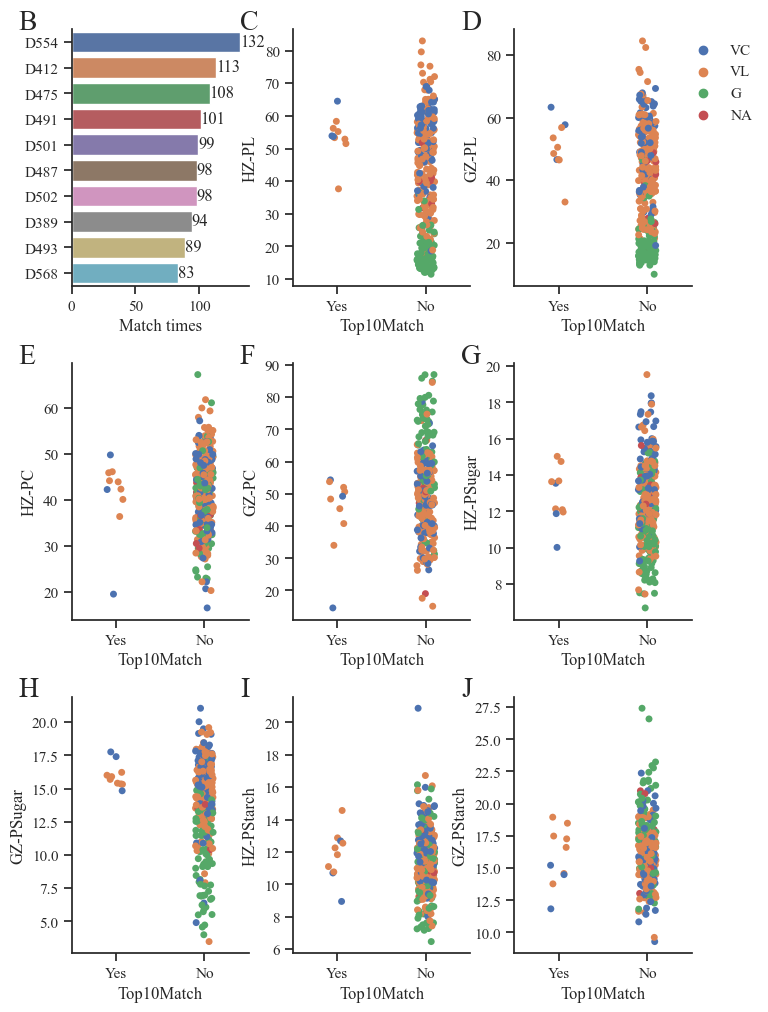

In [17]:
#plot_col = ["Barplot", 'HZ-PL', 'HZ-GNP', 'HZ-TSW', 'HZ-PSugar', 'HZ-PStarch', 'HZ-PProtein', 
#          'GZ-PL', 'GZ-TSW', 'GZ-PSugar', 'GZ-PStarch', 'GZ-PProtein']
plot_col = ["Barplot", 'HZ-PL', 'GZ-PL','HZ-PC', 'GZ-PC', 'HZ-PSugar', 'GZ-PSugar', 'HZ-PStarch', 'GZ-PStarch']
sns.set(font_scale=1, style="ticks")

letter_list = ['B','C','D',
               'E','F','G',
               'H','I','J']

def letter_annotation(ax, xoffset, yoffset, letter):

    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
            size=20, weight='bold')

ncols = 3
fig, axes = plt.subplots(nrows=3, ncols=ncols, figsize=(8, 12))
fig.subplots_adjust(wspace=0.25, hspace=0.3)
for num in range(len(plot_col)):
    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    if num == 0:
        sns.barplot(p2_top10, x="P2_donate_times", y="P2", orient="h", ax=axes[num//ncols, num%ncols])
        axes[num//ncols, num%ncols].bar_label(axes[num//ncols, num%ncols].containers[0])
        axes[num//ncols, num%ncols].set(xlabel="Match times", ylabel="")
    elif num == ncols-1:
        sns.stripplot(data=phenos_data, x="Top10Match", y=plot_col[num], 
                           hue="Type", order=["Yes", "No"], hue_order=['VC', 'VL', 'G', 'NA'],ax=axes[num//ncols, num%ncols])
        axes[num//ncols, num%ncols].legend(bbox_to_anchor=(0.9, 1), frameon=False)
    else:
        sns.stripplot(data=phenos_data, x="Top10Match", y=plot_col[num], 
                      hue="Type", order=["Yes", "No"], hue_order=['VC', 'VL', 'G', 'NA'],
                      ax=axes[num//ncols, num%ncols], legend=None)
    axes[num//ncols, num%ncols].spines[['right', 'top']].set_visible(False)

    letter_annotation(axes[num//ncols, num%ncols], -0.3, 1., letter_list[num])

plt.savefig(os.path.join(FIG_PATH, 'Fig_2B-J_plot_p2_top10.pdf'), format='pdf', bbox_inches='tight', transparent=True)
#plt.savefig(os.path.join(FIG_PATH, 'Fig_2B_plot_p2_top10.svg'), format='svg', bbox_inches='tight', transparent=True)

In [7]:
import string

In [9]:
list(string.ascii_uppercase)

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']